# Выбор локации для скважины добывающей компании

**Описание проекта**

Для добывающей компании необходимо определить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов.

**Цель исследования**

Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

**Задачи исследования**

- Построить модель и оценить объём запасов нефти;
- Выбрать месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Определить регион с максимальной суммарной прибылью отобранных скважин.

**Описание данных**
  
  -  `id` —  уникальный идентификатор скважины;
  -  `f0`, `f1`, `f2` —  три признака точек;
  -  `product` — объём запасов в скважине (тыс. баррелей).
  
**Дополнительные условия**

 - Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
 - При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
 - Бюджет на разработку скважин в регионе — 10 млрд рублей.
 - При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
 - После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Импорт используемых библиотек

In [ ]:
!pip install phik -q
!pip install scikit-learn --upgrade -q

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression

from sklearn.metrics import root_mean_squared_error, make_scorer

RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка и подготовка данных

### Загрузка данных

In [ ]:
try:
    data_geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
except FileNotFoundError:
    data_geo_0 = pd.read_csv('https://.../datasets/geo_data_0.csv')

In [ ]:
try:
    data_geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
except FileNotFoundError:
    data_geo_1 = pd.read_csv('https://.../datasets/geo_data_1.csv')

In [ ]:
try:
    data_geo_2 = pd.read_csv('/datasets/geo_data_2.csv')
except FileNotFoundError:
    data_geo_2 = pd.read_csv('https://...t/datasets/geo_data_2.csv')

Ознакомимся с данными:

In [ ]:
#универсальная функция для ознакомления с данными
def data_review(data):
    '''
    data - DataFrame

    '''
    print('*'*10, 'The Original DataFrame', '*'*10)
    display(data.head())
    print('')
    print('')
    print('*'*10, 'General Information', '*'*10)
    print('')
    data.info()
    print('')
    print('')
    print('*'*10, 'Has NaN', '*'*10)
    display(data.isna().sum())
    print('')
    print('')
    print('*'*10, 'Descriptive Statistics', '*'*10)
    display(data.describe())

In [ ]:
data_review(data_geo_0)

********** The Original DataFrame **********


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647




********** General Information **********

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


********** Has NaN **********


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64



********** Descriptive Statistics **********


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [ ]:
data_review(data_geo_1)

********** The Original DataFrame **********


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305




********** General Information **********

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


********** Has NaN **********


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64



********** Descriptive Statistics **********


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [ ]:
data_review(data_geo_2)

********** The Original DataFrame **********


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746




********** General Information **********

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


********** Has NaN **********


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64



********** Descriptive Statistics **********


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


#### Выводы

- названия столбцов соответсвуют стандартам;
- типы данных соответствуют содержанию столбцов;
- пропуски в столбцах не обнаружены.

###  Предобработка данных

Перед началом предобработки исходного датасета, пересохраним его в переменную df_x и создадим список датасетов:

In [ ]:
df_geo_0 = data_geo_0.copy()
df_geo_1 = data_geo_1.copy()
df_geo_2 = data_geo_2.copy()

dfs = [df_geo_0, df_geo_1, df_geo_2]
dfs_dict = {
    'df_geo_0': df_geo_0,
    'df_geo_1': df_geo_1,
    'df_geo_2': df_geo_2
}

Проверим датасеты на наличие явных (полных) дубликатов скважин.

In [ ]:
for df in dfs:
    print(df.duplicated().sum())

0
0
0


Явных дубликатов не обнаружено.

Проверим датасеты на наличие дубликатов скважин по id.

In [ ]:
for name, df in dfs_dict.items():
    diplicated_rows = df[df.duplicated(['id'])]['id'].count()
    print('*'*10,'Name:', name, '*'*10, '\n')
    print('Number of Duplicates:', diplicated_rows, '\n')

********** Name: df_geo_0 ********** 

Number of Duplicates: 10 

********** Name: df_geo_1 ********** 

Number of Duplicates: 4 

********** Name: df_geo_2 ********** 

Number of Duplicates: 4 



Удалим дублирующиеся скважины:

In [ ]:
for df in dfs:
    df.drop_duplicates(subset=['id'], inplace=True)

Проверим, что дубликаты в столбце `id` удалены:

In [ ]:
for name, df in dfs_dict.items():
    diplicated_rows = df[df.duplicated(['id'])]['id'].count()
    print('*'*10,'Name:', name, '*'*10, '\n')
    print('Number of Duplicates:', diplicated_rows, '\n')

********** Name: df_geo_0 ********** 

Number of Duplicates: 0 

********** Name: df_geo_1 ********** 

Number of Duplicates: 0 

********** Name: df_geo_2 ********** 

Number of Duplicates: 0 



#### Выводы

- В датафреймах отсутствуют явные (полные) дубликаты;
- Обнаружены дубликаты в столбце `id`, означающие наличие различных признаков для одной и той же скважины, что может исказить работу модели;
- Обнаруженные дубликаты скважин удалены.

## Исследовательский анализ данных

### Графический анализ признаков

Для быстрого анализа столбцов создадим собственную функцию, которая построит для каждого количественного столбца постоить гистограмму и ящик с усами:

In [ ]:
def num_to_scan(df, col):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Histogram
    sns.histplot(df, x=col, bins=20, ax=axes[0])
    axes[0].set_title(col)

    # Boxplot
    df.boxplot(column=col, ax=axes[1])
    axes[1].set_ylabel(col)

    plt.show()

********** Name: df_geo_0 ********** 



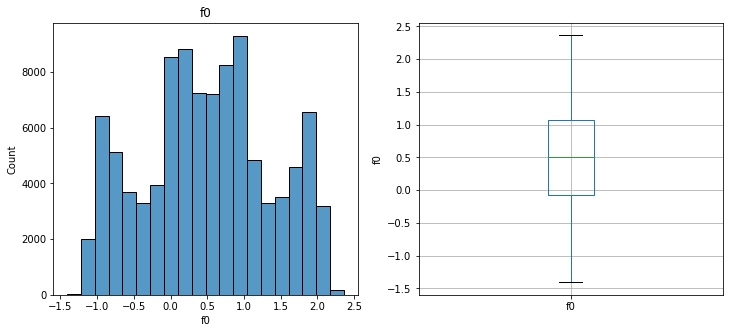

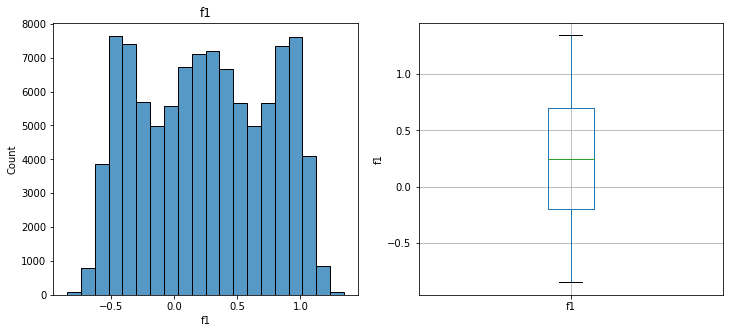

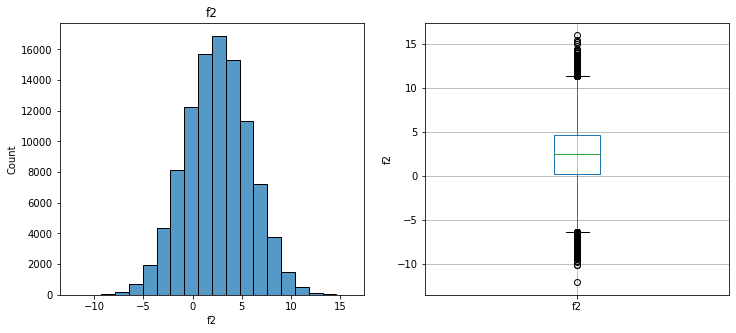

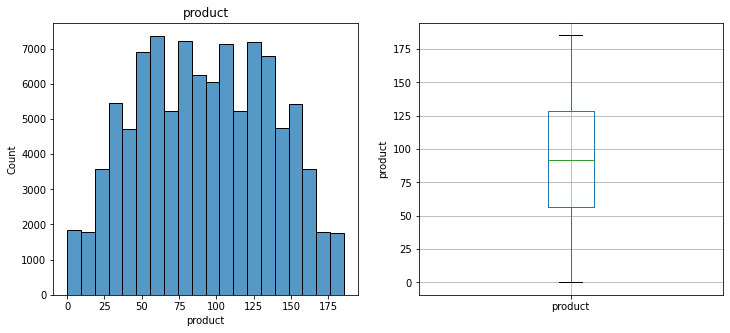

********** Name: df_geo_1 ********** 



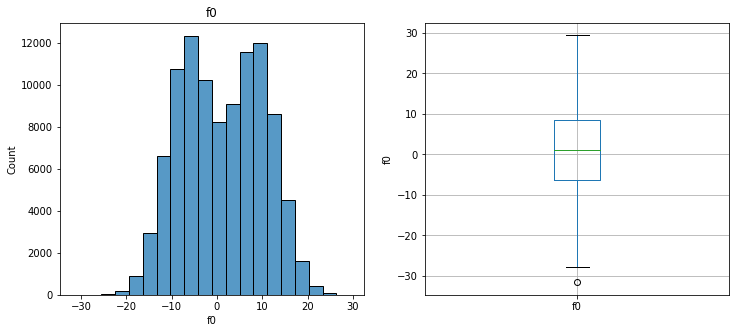

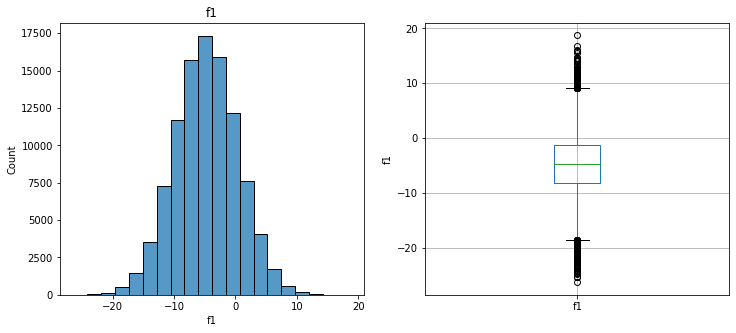

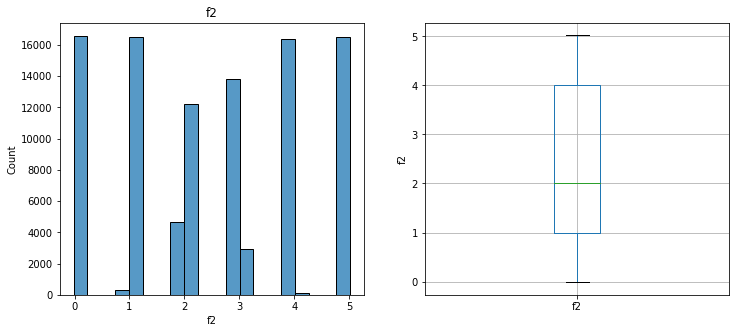

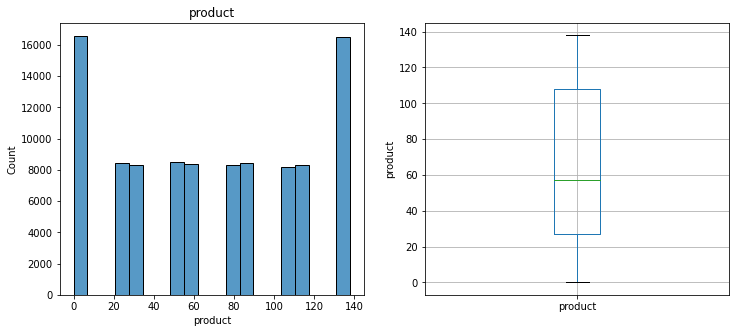

********** Name: df_geo_2 ********** 



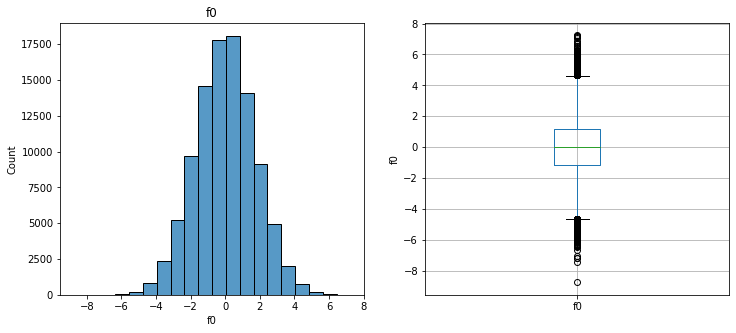

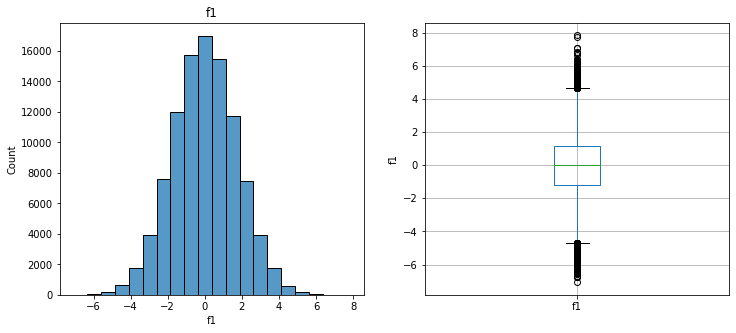

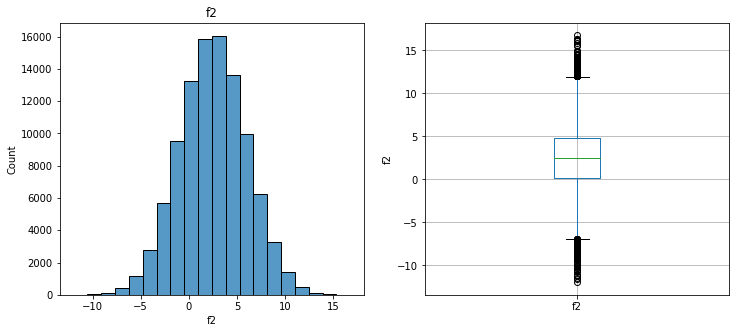

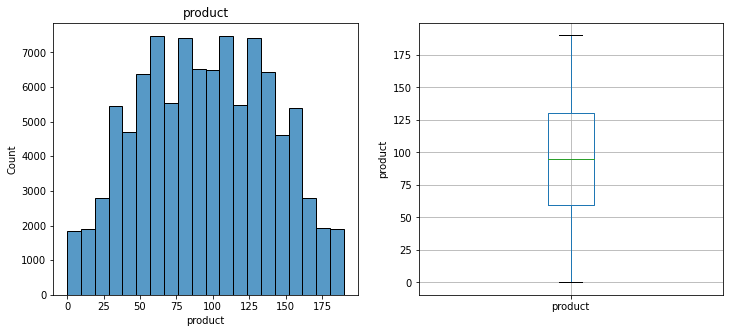

In [ ]:
for name, df in dfs_dict.items():
    print('*'*10,'Name:', name, '*'*10, '\n')
    for col in df.columns:
        if col == 'id':
            continue
        else:
            num_to_scan(df, col)

#### Выводы

Датафрейм `df_geo_0`:

1. Столбец `f0` - имеет трехпиковое распределение, выбросы за границами размаха усов не обнаружены;
2. Столбец `f1` - также имеет трехпиковое распределение, выбросы за границами размаха усов не обнаружены;
3. Столбец `f2` - имеет нормальное распределение, содержит выбросы за границами размаха усов. Данный признак важен для определения качества нефти, выбросы не предполагаются к удалению;
4. Столбец `product` - имеет нормальное распределение, выбросы за границами размаха усов не обнаружены.

Датафрейм `df_geo_1`:

1. Столбец `f0` - имеет двухпиковое распределение, обнаружен единичный выброс за границей размаха усов;
2. Столбец `f1` - имеет нормальное распределение, содержит выбросы за границами размаха усов. Данный признак важен для определения качества нефти, выбросы не предполагаются к удалению;
3. Столбец `f2` - имеет дискретную природу. Анализ значений из гистограммы и загрузки данных показал, что показатели сгруппированы вокруг 6 значений, однако не являются целочисленными. Предположительно, являются следствием особенностей работы конкретного оборудования.
4. Столбец `product` - имеет дискретную природу. Анализ значений из гистограммы и загрузки данных показал, что показатели сгруппированы вокруг 6 значений, однако не являются целочисленными. Предположительно, являются следствием особенностей работы конкретного оборудования.

Датафрейм `df_geo_2`:

1. Столбец `f0` - имеет нормальное распределение, содержит выбросы за границами размаха усов. Данный признак важен для определения качества нефти, выбросы не предполагаются к удалению;
2. Столбец `f1` - имеет нормальное распределение, содержит выбросы за границами размаха усов. Данный признак важен для определения качества нефти, выбросы не предполагаются к удалению;
3. Столбец `f2` - имеет нормальное распределение, содержит выбросы за границами размаха усов. Данный признак важен для определения качества нефти, выбросы не предполагаются к удалению;
4. Столбец `product` - имеет многопиковое распределение, выбросы за границами размаха усов не обнаружены.

В целом видно, что признаки, отвечающие за качество нефти имеют разные распределения в датафреймах, что свидетельствует о значительных различиях качества нефти в зависимости от региона.

Запасы нефти в регионах `df_geo_0` и `df_geo_2` имеют схожие значения. Распределение значений в регионе `df_geo_1` значительно отличается.

### Корреляционный анализ

Проверим признаки на коллинеарность и мультиколлинеорность:

************************* Name: df_geo_0 ************************* 



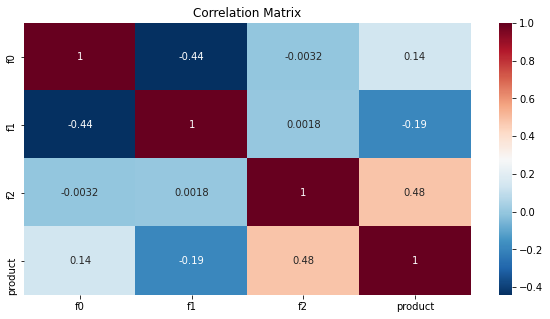

************************* Name: df_geo_1 ************************* 



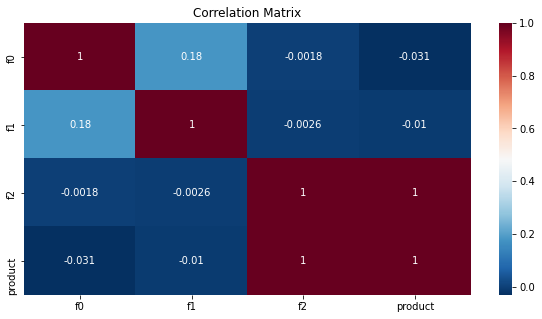

************************* Name: df_geo_2 ************************* 



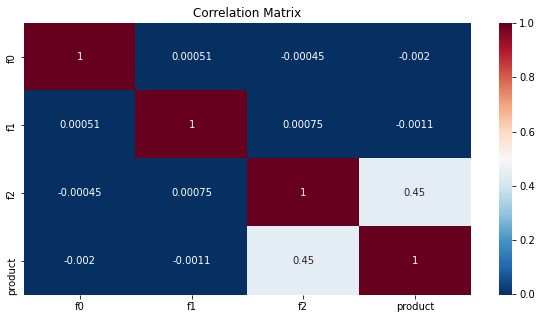

In [ ]:
for name, df in dfs_dict.items():
    print('*'*25,'Name:', name, '*'*25, '\n')
    df_corr = df.drop('id', axis=1)
    corr_matrix = df_corr.corr()

    plt.figure(figsize=(10, 5))
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r')
    plt.title('Correlation Matrix')
    plt.show();

#### Выводы

Датафрейм `df_geo_0`:

1. Мультиколлинеарности (очень высоких корреляций (0.9 +)) среди входных признаков  не обнаружено. Самая высокая отрицательная коллинеарность выявлена между признаками `f0`и `f1`, равная -0.44.

2. Целевой признак `product` имеет умеренную корреляцию с входным признаком `f2` - 0.48.

Датафрейм `df_geo_1`:

1. Мультиколлинеарности (очень высоких корреляций (0.9 +)) среди входных признаков  не обнаружено.

2. Целевой признак `product` имеет полную корреляцию с входным признаком `f2` - 1.00.

Датафрейм `df_geo_2`:

1. Мультиколлинеарности (очень высоких корреляций (0.9 +)) среди входных признаков  не обнаружено.

2. Целевой признак `product` имеет умеренную корреляцию с входным признаком `f2` - 0.45.

В целом можно отметить, что корреляция в регионах датафреймов `df_geo_0` и `df_geo_2` имеют схожие значения.
Зависимость целевого признака от входных в регионе датафрейма `df_geo_1` значительно отличается и, учитывая дискретность признака `f2`, указывает на особенности применяемого в регионе оборудования при определении значений признака `f2` и, как следствие, аналогичная дискретность значений целевого признака `product`.  

## Обучение и проверка моделей

Обучим и проверим модели для каждого региона для предсказания объёма запасов в новых скважинах.

### Подготовка данных

Создадим функцию для подготовки данных:

In [ ]:
#функция для подготовки данных
def prepare_data(df):
    X = df.drop(['id', 'product'], axis=1)
    y = df['product']

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE
    )
    num_col_names = X_train.select_dtypes(include='number').columns.tolist()

    return X_train, X_test, y_train, y_test, num_col_names

Проверим размеры и размерности для каждого региона и определим переменную num_col_names для дальнейшего ее использования в пайплайне:

In [ ]:
for name, df in dfs_dict.items():
    X_train, X_test, y_train, y_test, num_col_names = prepare_data(df)
    print(f'Размеры тренировочной и тестовой выборок для {name}:\
{X_train.shape, X_test.shape, y_train.shape, y_test.shape} \n')

Размеры тренировочной и тестовой выборок для df_geo_0:((74992, 3), (24998, 3), (74992,), (24998,)) 

Размеры тренировочной и тестовой выборок для df_geo_1:((74997, 3), (24999, 3), (74997,), (24999,)) 

Размеры тренировочной и тестовой выборок для df_geo_2:((74997, 3), (24999, 3), (74997,), (24999,)) 



### Обучение моделей

Создадим пайплайн для обучения моделей:

In [ ]:
data_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_col_names)
],
    remainder='passthrough'
)

In [ ]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

Создадим словарь моделей с гиперпараметрами для поиска лучшей модели методом GridSearchCV. По условию задачи подходит только модель линейной регрессии.

In [ ]:
param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
]

Создадим автоматический поиск лучшей модели методом GridSearchCV с метрикой RMSE. Для поиска лучшей метрики создадим собственную с параметром `greater_is_better=False`.

In [ ]:
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

In [ ]:
grid_search = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv=5,
    scoring=rmse_scorer,
    n_jobs=-1
)

In [ ]:
dfs_product_dict = {}

for name, df in dfs_dict.items():
    print('*'*35,'Name:', name, '*'*35, '\n')
    X_train, X_test, y_train, y_test, num_col_names = prepare_data(df)
    grid_search.fit(X_train, y_train)
    print(f'RMSE на тренировочной выборке для региона {name}: {grid_search.best_score_:.2f}')
    y_test_pred = grid_search.best_estimator_.predict(X_test)
    print(f'Средний запас предсказанного сырья для региона df_geo_0: {y_test_pred.mean():.2f}')
    print(f'RMSE на валидационной выборке для региона df_geo_0: {root_mean_squared_error(y_test, y_test_pred):.2f} \n\n\n')
    product_true_pred = y_test.to_frame()
    product_true_pred['product_pred'] = y_test_pred
    dfs_product_dict[str(name)] = product_true_pred

print('-'*85)
print(f'Лучшая модель: {grid_search.best_estimator_}')
print('-'*85)

*********************************** Name: df_geo_0 *********************************** 

RMSE на тренировочной выборке для региона df_geo_0: -37.70
Средний запас предсказанного сырья для региона df_geo_0: 92.61
RMSE на валидационной выборке для региона df_geo_0: 37.69 



*********************************** Name: df_geo_1 *********************************** 

RMSE на тренировочной выборке для региона df_geo_1: -0.89
Средний запас предсказанного сырья для региона df_geo_0: 68.58
RMSE на валидационной выборке для региона df_geo_0: 0.89 



*********************************** Name: df_geo_2 *********************************** 

RMSE на тренировочной выборке для региона df_geo_2: -40.05
Средний запас предсказанного сырья для региона df_geo_0: 94.93
RMSE на валидационной выборке для региона df_geo_0: 40.08 



-------------------------------------------------------------------------------------
Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='pas

Выведем на экран первые пять значений полученных датафреймов с предсказаниями и правильными ответами на валидационной выборке

In [ ]:
for name, df in dfs_product_dict.items():
    print('*'*5,'Name:', name, '*'*5)
    display(dfs_product_dict.get(name, 'default value').head())
    print()

***** Name: df_geo_0 *****


,product,product_pred
33966,119.813252,127.486528
22854,133.296862,116.465831
19449,25.310435,66.041910
9733,65.422491,45.009390
7129,140.851476,124.535557



***** Name: df_geo_1 *****


,product,product_pred
33968,0.000000,1.745635
24612,134.766305,135.730891
42678,134.766305,133.539653
9732,30.132364,28.844517
7129,137.945408,138.037182



***** Name: df_geo_2 *****


,product,product_pred
33968,156.925842,111.540811
24612,31.245818,66.812289
42677,48.478519,70.406921
9732,34.079047,63.118690
7129,138.077543,141.162178


### Выводы

- Регионы df_geo_0 и df_geo_2 показали схожие средние запасы предсказанного сырья. Однако модель для региона df_geo_0 показала меньшую ошибку RMSE, а значит предсказания ее точнее;
- В регионе df_geo_1 средние заказы предсказанного сырья меньше на 30 %. Точность предсказаний модели определена полной корреляцией целевого признака с входным признаком `f2` - 1.00.

## Подготовка к расчёту прибыли

### Достаточный объем сырья для безубыточной разработки новой скважины

Сохраним в переменных ключевые значения для расчета прибыли:

In [ ]:
# бюджет на разработку скважин в регионе в млн. руб.
BUDGET = 10_000

# доход с каждой единицы продукта в млн. руб.
BBL_1000 = 0.45

# количество исследуемых скважин в регионе
OIL_WELL_AMOUNT_ALL = 500

# количество скважин для разработки в регионе
OIL_WELL_AMOUNT = 200

Рассчитаем достаточный объем сырья для безубыточной разработки новой скважины:

In [ ]:
break_even_point = BUDGET / OIL_WELL_AMOUNT / BBL_1000
print(f'Достаточный объем сырья для безубыточной разработки новой скважины: {break_even_point:.2f}')

Достаточный объем сырья для безубыточной разработки новой скважины: 111.11


#### Выводы

Средний запас предсказанного сырья по регионам не превосходит рассчитанного достаточного объема для безубыточной разработки новой скважины. Это означает, что при рандомном бурении 200 скважин высока вероятность получения убытка.

### Функция для расчёта прибыли

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

In [ ]:
def best_oil_well_revenue(df):
    revenue = df.sort_values(by='product_pred', ascending=False)['product'].head(OIL_WELL_AMOUNT).sum()*BBL_1000 - BUDGET
    return revenue

In [ ]:
for name, df in dfs_product_dict.items():
    print('*'*10,'Name:', name, '*'*10, '\n')
    revenue = best_oil_well_revenue(df)
    print(f'Прибыль от 200 лучших скважин для региона {name}: {revenue:.0f} млн.руб. \n')

********** Name: df_geo_0 ********** 

Прибыль от 200 лучших скважин для региона df_geo_0: 3469 млн.руб. 

********** Name: df_geo_1 ********** 

Прибыль от 200 лучших скважин для региона df_geo_1: 2415 млн.руб. 

********** Name: df_geo_2 ********** 

Прибыль от 200 лучших скважин для региона df_geo_2: 2397 млн.руб. 



#### Выводы

При разработке 200 скважин с максимальными значениями предсказаний разработка скважин окупится в каждом регионе.

## Расчёт прибыли и рисков

Напишем функцию для подсчета прибыли и рисков для каждого региона техникой Bootstrap на 1000 выборок.

In [ ]:
def bootstrap(df):
    state = np.random.RandomState(RANDOM_STATE)
    values = []
    for i in range(1000):
        product_subsample = df[['product', 'product_pred']].sample(n=OIL_WELL_AMOUNT_ALL, replace=True, random_state=state)
        revenue = best_oil_well_revenue(product_subsample)
        values.append(revenue)
    values = pd.Series(values)
    revenue_mean = values.mean()
    low = values.quantile(0.025)
    high = values.quantile(0.975)
    risk_of_loss = (values<0).mean()
    return revenue_mean, low, high, risk_of_loss

In [ ]:
for name, df in dfs_product_dict.items():
    print('*'*25,'Name:', name, '*'*25, '\n')
    revenue_mean, low, high, risk_of_loss = bootstrap(df)
    print(f'Средняя прибыль для региона {name} по технике Bootstrap: {revenue_mean:.0f} млн.руб.')
    print(f'95 % доверительный интервал прибыли для региона {name}: от {low:.0f} млн.руб. до {high:.0f} млн.руб.')
    print(f'Риск получения убытков в регионе {name}: {risk_of_loss * 100:.1f} %')
    print()

************************* Name: df_geo_0 ************************* 

Средняя прибыль для региона df_geo_0 по технике Bootstrap: 404 млн.руб.
95 % доверительный интервал прибыли для региона df_geo_0: от -138 млн.руб. до 903 млн.руб.
Риск получения убытков в регионе df_geo_0: 5.9 %

************************* Name: df_geo_1 ************************* 

Средняя прибыль для региона df_geo_1 по технике Bootstrap: 430 млн.руб.
95 % доверительный интервал прибыли для региона df_geo_1: от 43 млн.руб. до 847 млн.руб.
Риск получения убытков в регионе df_geo_1: 1.6 %

************************* Name: df_geo_2 ************************* 

Средняя прибыль для региона df_geo_2 по технике Bootstrap: 384 млн.руб.
95 % доверительный интервал прибыли для региона df_geo_2: от -128 млн.руб. до 910 млн.руб.
Риск получения убытков в регионе df_geo_2: 8.0 %



### Выводы

На основе расчитанных техникой Bootstrap на 1000 выборок прибылей и рисков для каждого региона можно сделать вывод о целесообразности разработки скважин в регионе **1 (df_geo_1)**. Данные регион содержит самый высокий показатель средней прибыли. 95 % доверительный интервал исключает возможность убытков. Риск убытков составляет 1.6 %, что является минимальным значением из трех регионов.

Однако стоит обратить внимание на то, что в результате исследовательского анализа данных, была выявлена отличная от других регионов природа признаков `f2` и объёма запасов в скважине. Данные значения дискретные и полностью коррелирующие, что позволяет модели согласно метрике RMSE с минимальной ошибкой предсказывать объем запасов нефти в скважине. Рекомендуется определить природу полученных значений и, в случае выявления недостаточности или недостоверности исходных данных, провести повторное исследование.